# Assignment

Forecast the CocaCola prices data set.

Prepare a document for each model explaining how many dummy variables you have created and MAE value for each model.

Finally which model you will use for Forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
coco_df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
coco_df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [3]:
coco_df.shape

(42, 2)

In [4]:
coco_df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
coco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
coco_df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [7]:
# converting into datetime format as the index was not in correct format.
# joining the number 19 before quarter to make to as complete year
coco_df['Quarter_Year'] = coco_df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

In [8]:
coco_df.head()

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


In [9]:
#Extract date from the quarters
coco_df['Date'] = (pd.to_datetime(coco_df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))

In [10]:
coco_df['Quarters'] = 0

for i in range(42):
    n = coco_df['Quarter'][i]
    coco_df['Quarters'][i] = n[0:2]
    
coco_df.head(5)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [11]:
#Create dummy variable for quarters
dummy = pd.DataFrame(pd.get_dummies(coco_df['Quarters']))
coco_data = pd.concat((coco_df, dummy), axis=1)
coco_data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [12]:
#Dropping the Quarter and Quarter_Year
coco_data.drop(['Quarter','Quarter_Year'],axis=1,inplace=True)
coco_data.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [13]:
coco_data1= coco_data.copy()
coco_data1.set_index('Date',inplace=True)

In [14]:
coco_data1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


<AxesSubplot: xlabel='Date'>

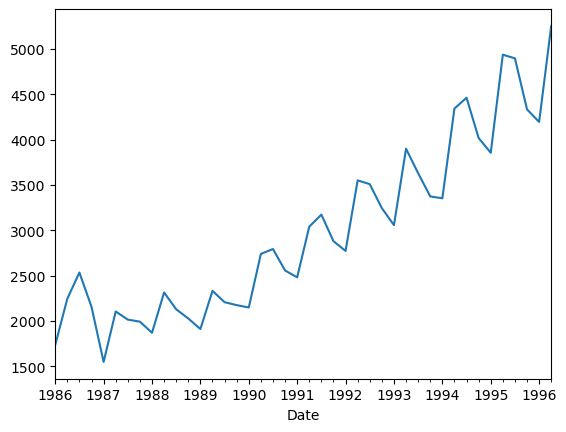

In [15]:
coco_data1.Sales.plot()

<AxesSubplot: >

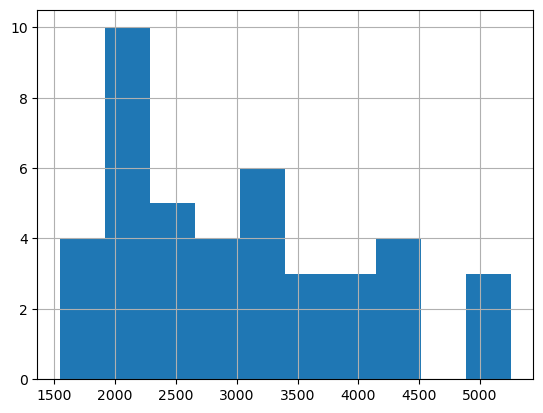

In [16]:
coco_data1.Sales.hist()

<AxesSubplot: xlabel='Sales', ylabel='Density'>

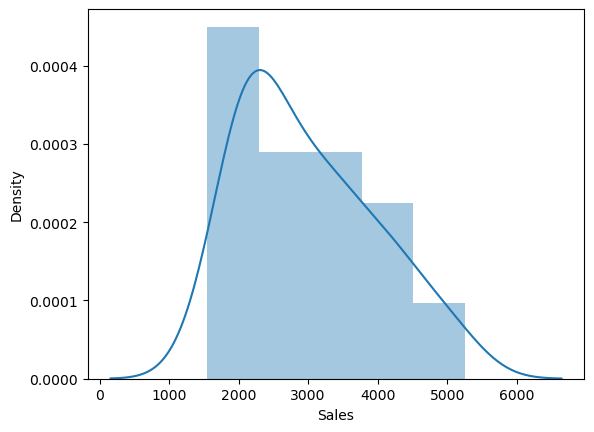

In [17]:
sns.distplot(coco_data1.Sales)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

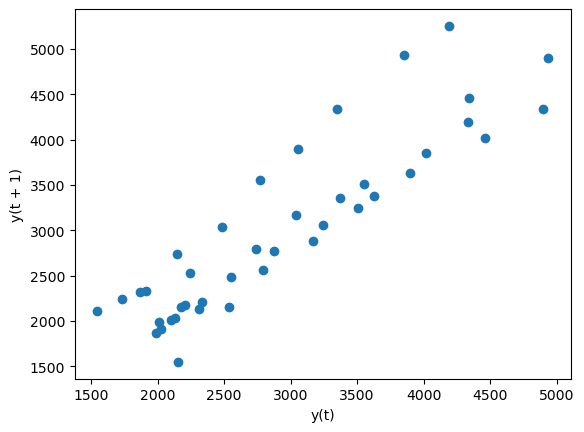

In [18]:
#Lagplot
lag_plot(coco_data1.Sales)

In [19]:
#Getting month and year columns 
coco_data['Date'] = pd.to_datetime(coco_data.Date,format='%b-%y')
coco_data["month"] = coco_data.Date.dt.strftime("%b")
coco_data["year"] = coco_data.Date.dt.strftime("%Y")
coco_data.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4,month,year
0,1734.827000,1986-01-01,Q1,1,0,0,0,Jan,1986
1,2244.960999,1986-04-01,Q2,0,1,0,0,Apr,1986
2,2533.804993,1986-07-01,Q3,0,0,1,0,Jul,1986
3,2154.962997,1986-10-01,Q4,0,0,0,1,Oct,1986
4,1547.818996,1987-01-01,Q1,1,0,0,0,Jan,1987


<AxesSubplot: xlabel='Quarters', ylabel='Sales'>

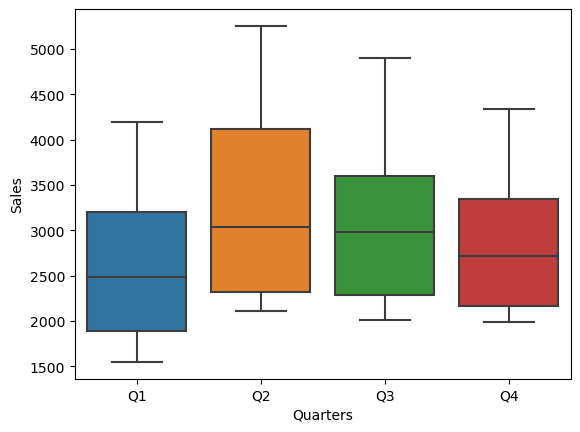

In [20]:
#boxplot for Quarteres w.r.to sales
sns.boxplot(x="Quarters",y="Sales",data=coco_data)

<AxesSubplot: xlabel='year', ylabel='Sales'>

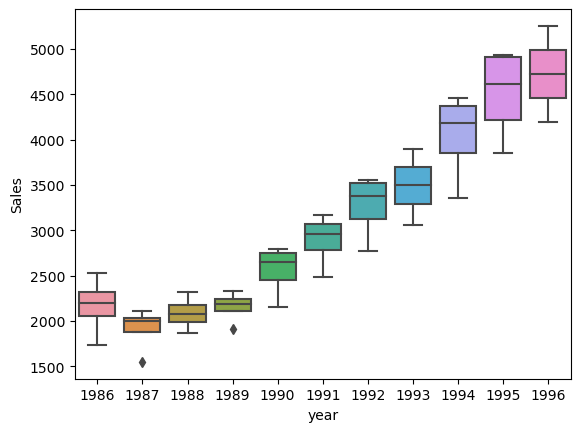

In [21]:
#boxplot for years w.r.to sales
sns.boxplot(x="year",y="Sales",data=coco_data)

<AxesSubplot: xlabel='year', ylabel='Sales'>

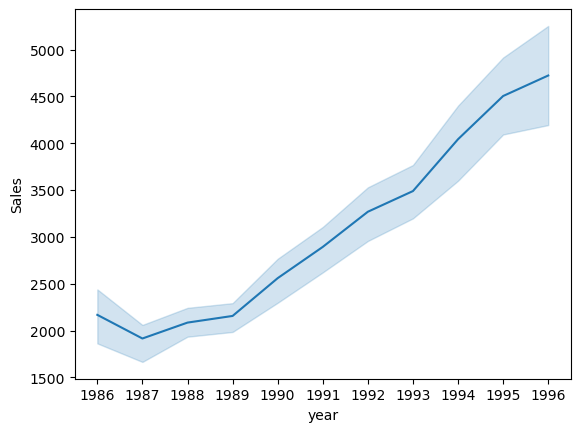

In [22]:
#lineplot
sns.lineplot(x='year',y='Sales',data=coco_data)

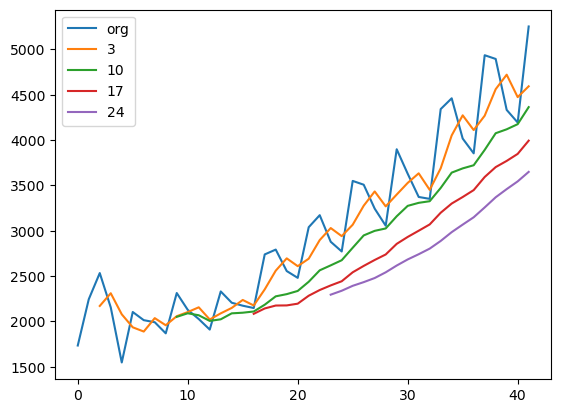

In [23]:
#Moving Average
coco_data.Sales.plot(label="org")
for i in range(3,30,7):
    coco_data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

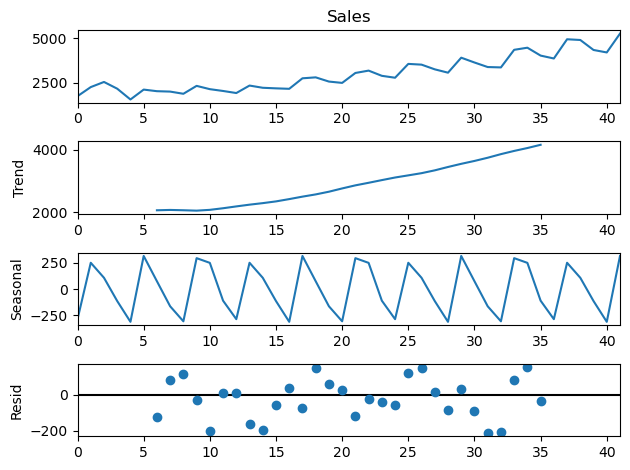

In [24]:
#Time Series Decomposition plot
seasonal_decompose(coco_data.Sales,period=12).plot()
plt.show()

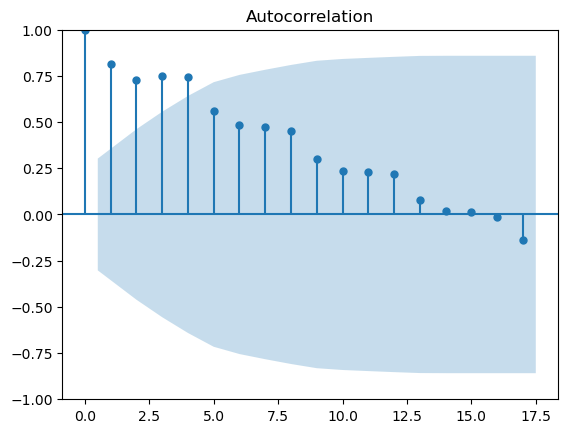

In [25]:
#ACF plot
tsa_plots.plot_acf(coco_data['Sales'])
plt.show()

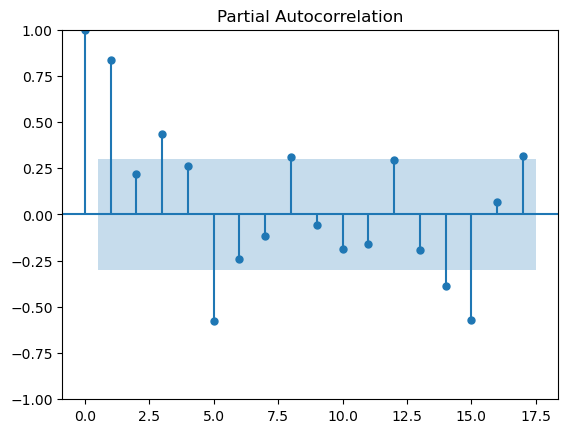

In [26]:
tsa_plots.plot_pacf(coco_data['Sales'])
plt.show()

In [27]:
#Data Preprocessing
#for the timesteps are taking the numbers from 1 to 43(Size of the dataset rows)
x = np.arange(1,43)

In [28]:
t = pd.Series(data=x)
t_sqr = pd.Series(data=(x*x))

In [29]:
coco_data['log_sales'] = np.log(coco_data['Sales'])
coco_data['t'] = t
coco_data['t_sqr'] = t_sqr

In [30]:
coco_data.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4,month,year,log_sales,t,t_sqr
0,1734.827000,1986-01-01,Q1,1,0,0,0,Jan,1986,7.458663,1,1
1,2244.960999,1986-04-01,Q2,0,1,0,0,Apr,1986,7.716443,2,4
2,2533.804993,1986-07-01,Q3,0,0,1,0,Jul,1986,7.837477,3,9
3,2154.962997,1986-10-01,Q4,0,0,0,1,Oct,1986,7.675529,4,16
4,1547.818996,1987-01-01,Q1,1,0,0,0,Jan,1987,7.344602,5,25


In [31]:
#Spliting the dataset for traing and testing
train = coco_data.head(30)
test = coco_data.tail(12)

In [32]:
#function for getting MAE(Mean Absolute Error value)
def MAE(pred,org):
    temp = np.abs((pred-org)/org)
    return np.mean(temp)

In [33]:
model_linear = smf.ols('Sales~t',data=train).fit()
pred_linear =  pd.Series(model_linear.predict(pd.DataFrame(test['t'])))                                              #predict on test data   
mae_linear = MAE(test['Sales'],pred_linear)                                                                     #calculate eoot mean sqr error 
mae_linear

0.15390960798745937

In [34]:
#Exponential
model_exp = smf.ols('log_sales~t',data=train).fit()
pred_exp = pd.Series(model_exp.predict(pd.DataFrame(test['t'])))
mae_exp = MAE(test['Sales'], np.exp(pred_exp))
mae_exp

0.11010762144393449

In [35]:
#Quadratic 
model_quad = smf.ols('Sales~t+t_sqr',data=train).fit()
pred_quad = pd.Series(model_quad.predict(test[["t","t_sqr"]]))
mae_quad = MAE(test['Sales'],pred_quad)
mae_quad

0.10558313155976685

In [36]:
#Additive seasonality 
model_add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea = pd.Series(model_add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
mae_add_sea = MAE(test['Sales'],pred_add_sea)
mae_add_sea

0.6840229690452245

In [37]:
#Additive Seasonality Quadratic 
model_add_sea_quad = smf.ols('Sales~t+t_sqr+Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea_quad = pd.Series(model_add_sea_quad.predict(test[['Q1','Q2','Q3','Q4','t','t_sqr']]))
mae_add_sea_quad = MAE(test['Sales'], pred_add_sea_quad)
mae_add_sea_quad

0.10915490303385657

In [38]:
##Multiplicative Seasonality
model_mult_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4',data = train).fit()
pred_mult_sea = pd.Series(model_mult_sea.predict(test))
mae_mult_sea = MAE(test['Sales'], np.exp(pred_mult_sea))
mae_mult_sea

0.7197711999139446

In [39]:
#Multiplicative Additive Seasonality 

model_Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3+Q4',data = train).fit()
pred_Mult_add_sea = pd.Series(model_Mul_Add_sea.predict(test))
mae_Mult_add_sea = MAE(test['Sales'], np.exp(pred_Mult_add_sea))
mae_Mult_add_sea

0.09114335527296401

In [40]:
#Forecasting by DataDriven Model

In [41]:
coco_df.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [42]:
Train = coco_df.head(30)
Test = coco_df.head(12)

In [43]:
#Simple Exponential method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAE_ses = MAE(pred_ses,Test.Sales) 
MAE_ses

0.11964167096987259

In [44]:
#Hotl method
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAE_hw = MAE(pred_hw,Test.Sales) 
MAE_hw

0.15123246672351848

In [45]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAE__hwe_add_add = MAE(pred_hwe_add_add,Test.Sales) 
MAE__hwe_add_add

0.059895036384720386

In [46]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAE__hwe_mul_add = MAE(pred_hwe_mul_add,Test.Sales)
MAE__hwe_mul_add

0.06053500637861326

In [48]:
#Compare the results 
data = {"MODEL":pd.Series(["MAE_linear","MAE_Exp","MAE_Quad","MAE_add_sea","MAE_add_sea_quad","MAE_Mult_sea","MAE_Mult_add_sea","MAE_ses","MAE_hw","MAE_hwe_add_add","MAE_hwe_mul_add"]),
        "MAE_Values":pd.Series([mae_linear,mae_exp,mae_quad,mae_add_sea,mae_add_sea_quad,mae_mult_sea,mae_Mult_add_sea,MAE_ses,MAE_hw,MAE__hwe_add_add,MAE__hwe_mul_add])}
table_mae=pd.DataFrame(data)
table_mae.sort_values(['MAE_Values'])

,MODEL,MAE_Values
9,MAE_hwe_add_add,0.059895
10,MAE_hwe_mul_add,0.060535
6,MAE_Mult_add_sea,0.091143
2,MAE_Quad,0.105583
4,MAE_add_sea_quad,0.109155
1,MAE_Exp,0.110108
7,MAE_ses,0.119642
8,MAE_hw,0.151232
0,MAE_linear,0.153910
3,MAE_add_sea,0.684023


In [49]:
#Comparing HWE smoothing with mul seasonality and add trend predicted vales
#with the actual values
pred_hwe_mul_add

0     1888.787596
1     2235.137044
2     2286.179216
3     2295.074842
4     1964.243126
5     2121.959823
6     2087.105667
7     1897.826391
8     1882.548277
9     2312.098898
10    2293.295738
11    1977.159215
dtype: float64

In [50]:
cmp_df = pd.DataFrame(Test['Sales'])
cmp_df['Forecast_Sales'] = pred_hwe_mul_add
cmp_df

,Sales,Forecast_Sales
0,1734.827000,1888.787596
1,2244.960999,2235.137044
2,2533.804993,2286.179216
3,2154.962997,2295.074842
4,1547.818996,1964.243126
5,2104.411995,2121.959823
6,2014.362999,2087.105667
7,1991.746998,1897.826391
8,1869.049999,1882.548277
9,2313.631996,2312.098898


<AxesSubplot: >

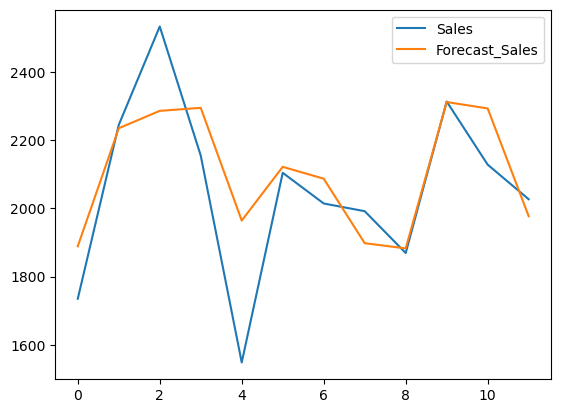

In [51]:
cmp_df[['Sales','Forecast_Sales']].plot()